This notebook is heavily based on the one from:
https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/

#### Preamble

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as pl

In [3]:
import numpy as np
import numpy.random as rnd
from scipy.stats import norm

from keras import backend as K

from keras.layers import (Input, InputLayer, Dense, Lambda, Layer, 
                          Add, Multiply)
from keras.models import Model, Sequential
from keras.datasets import mnist

Using TensorFlow backend.


In [4]:
from polys.keras_layers import CatmullRomLayer

In [5]:
import pandas as pd

from matplotlib.ticker import FormatStrFormatter
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

#### Notebook Configuration 

In [6]:
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)

In [7]:
'TensorFlow version: ' + K.tf.__version__

'TensorFlow version: 1.11.0'

#### Generate Dataset

In [8]:
def fun(t):
    z = np.exp((0.2 + 1j)*t)
    return np.stack([z.real, z.imag], axis = -1)

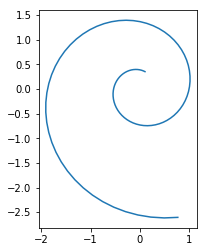

In [9]:
ttt = np.linspace(-5, 5, 100)

fig, ax = pl.subplots()
ax.set_aspect("equal")
pl.plot(*fun(ttt).T)

In [10]:
x_train = fun(rnd.normal(size = 1000))
x_test = fun(rnd.normal(size = 1000))

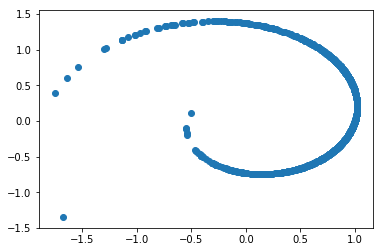

In [11]:
pl.scatter(*x_train.T)

##### Constant definitions

In [12]:
original_dim = 2
intermediate_dim = 32
latent_dim = 1
batch_size = 100
epochs = 50

## Model specification

### Encoder

#### Inference network

In [13]:
x = Input(shape=(original_dim,), name='x')
h = Dense(intermediate_dim, activation='relu', 
          name='hidden_enc')(x)
z_mu = Dense(latent_dim, name='mu')(h)
z_log_var = Dense(latent_dim, name='log_var')(h)
z_sigma = Lambda(lambda t: K.exp(.5*t), name='sigma')(z_log_var)

In [14]:
m = Model(inputs=x, outputs=[z_mu, z_sigma])

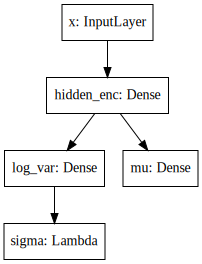

In [15]:
SVG(model_to_dot(m, show_shapes=False)
    .create(prog='dot', format='svg'))

#### Reparameterization with Merge Layers

In [16]:
z_mu = Input(shape=(latent_dim,), name='mu')
z_sigma = Input(shape=(latent_dim,), name='sigma')
eps = Input(shape=(latent_dim,), name='eps')
z_eps = Multiply(name='z_eps')([z_sigma, eps])
z = Add(name='z')([z_mu, z_eps])

In [17]:
m = Model(inputs=[eps, z_mu, z_sigma], outputs=z)

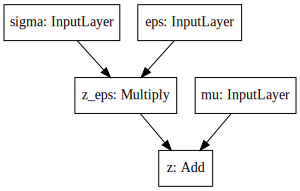

In [18]:
SVG(model_to_dot(m, show_shapes=False)
    .create(prog='dot', format='svg'))

#### Simplified architecture visualization

In [19]:
x = Input(shape=(original_dim,), name='x')
h = Dense(intermediate_dim, activation='relu', 
          name='hidden_enc')(x)
z_mu = Dense(latent_dim, name='mu')(h)
z_log_var = Dense(latent_dim, name='log_var')(h)
z_sigma = Lambda(lambda t: K.exp(.5*t), name='sigma')(z_log_var)

eps = Input(shape=(latent_dim,), name='eps')
z_eps = Multiply(name='z_eps')([z_sigma, eps])
z = Add(name='z')([z_mu, z_eps])

In [20]:
encoder = Model(inputs=[x, eps], outputs=z)

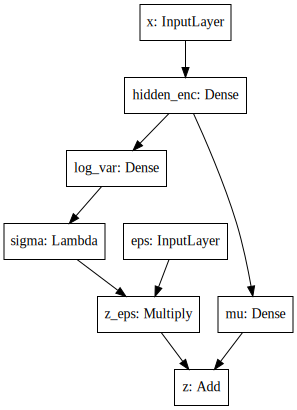

In [21]:
SVG(model_to_dot(encoder, show_shapes=False)
    .create(prog='dot', format='svg'))

#### Full architecture visualization with auxiliary layers

In [22]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [23]:
x = Input(shape=(original_dim,), name='x')
h = Dense(intermediate_dim, activation='relu', 
          name='hidden_enc')(x)
z_mu = Dense(latent_dim, name='mu')(h)
z_log_var = Dense(latent_dim, name='log_var')(h)
z_mu, z_log_var = KLDivergenceLayer(name='kl')([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t), name='sigma')(z_log_var)

eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], 
                                          latent_dim)), name='eps')
z_eps = Multiply(name='z_eps')([z_sigma, eps])
z = Add(name='z')([z_mu, z_eps])

In [24]:
encoder = Model(inputs=[x, eps], outputs=z)

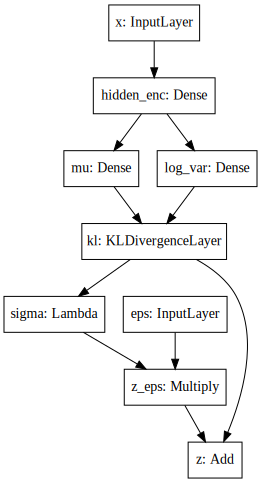

In [25]:
SVG(model_to_dot(encoder, show_shapes=False)
    .create(prog='dot', format='svg'))

### Decoder

In [28]:
decoder = Sequential([
  Dense(intermediate_dim, input_dim=latent_dim, 
        activation='relu', name='hidden_dec'),
  Dense(original_dim, activation='sigmoid', name='x_pred')
], name='decoder')

In [29]:
# equivalent to above. we specify InputLayer 
# explicitly to set layer name for architecture diagram 
decoder = Sequential([
    InputLayer(input_shape=(latent_dim,), name='z'),
    Dense(intermediate_dim, input_shape=(latent_dim,),
          activation='relu', name='hidden_dec'),
    Dense(original_dim, activation='sigmoid', name='x_pred')
], name='decoder')

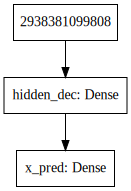

In [30]:
SVG(model_to_dot(decoder, show_shapes=False)
    .create(prog='dot', format='svg'))

### Specifying the VAE

In [31]:
x_pred = decoder(z)

In [32]:
# again, equivalent to above. fleshing it out fully
# for final end-to-end vae architecture visualization;
# otherwise, sequential models just get chunked into
# single layer
h_dec = Dense(intermediate_dim, activation='relu', 
              name='hidden_dec')(z)
x_pred = Dense(original_dim, activation='sigmoid', 
               name='x_pred')(h_dec)

In [33]:
vae = Model(inputs=[x, eps], outputs=x_pred)

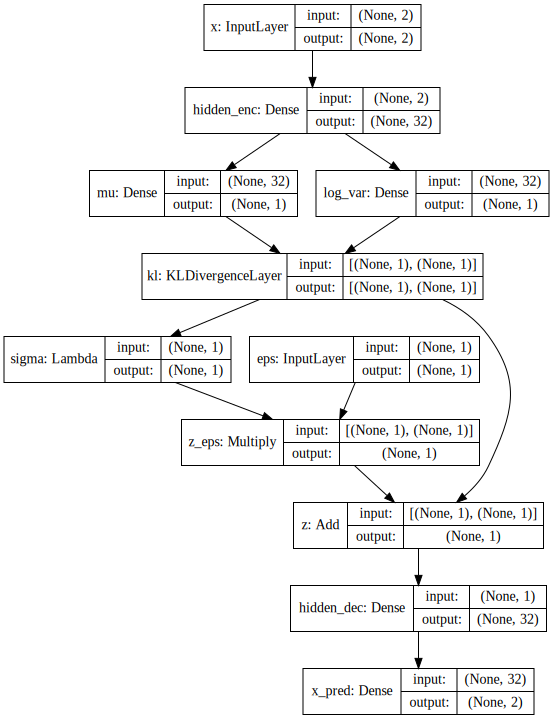

In [34]:
SVG(model_to_dot(vae, show_shapes=True)
    .create(prog='dot', format='svg'))

### Putting it all together

In [35]:
import keras.losses

In [50]:
import tensorflow as tf

In [ ]:
tf.distributions.Normal()

In [51]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Gauss with unit variance). """

    # keras.losses.mean_squared_error gives the mean
    # over the last axis. we require the sum
    sigma = 0.02
    return K.sum((y_true - y_pred)**2 / (2* sigma**2) , axis=-1)

In [52]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], 
                                          latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

decoder = CatmullRomLayer(
    controls = [np.linspace(-5, 5, 8)], 
    val_shape = [2], name = "Spline"
)

x_pred = decoder(z)

In [53]:
vae = Model(inputs=[x, eps], outputs=x_pred, name='vae')
vae.compile(optimizer='rmsprop', loss=nll)

In [54]:
t = Input(shape = [1], name = "t")

In [55]:
decoder_model = Model(inputs = t, outputs = decoder(t))

## Model fitting

In [56]:
hist = vae.fit(
    x_train,
    x_train,
    shuffle=True,
    epochs=1000,
    batch_size=batch_size,
    validation_data=(x_test, x_test)
)

Train on 1000 samples, validate on 1000 samples
Epoch 1/1000
1000/1000 [==============================] - 1s 891us/step - loss: 1327.8517 - val_loss: 1281.7228
Epoch 2/1000
1000/1000 [==============================] - 0s 34us/step - loss: 1301.7321 - val_loss: 1256.8224
Epoch 3/1000
1000/1000 [==============================] - 0s 23us/step - loss: 1280.4051 - val_loss: 1241.2640
Epoch 4/1000
1000/1000 [==============================] - 0s 18us/step - loss: 1258.0932 - val_loss: 1221.9382
Epoch 5/1000
1000/1000 [==============================] - 0s 19us/step - loss: 1237.7370 - val_loss: 1199.7986
Epoch 6/1000
1000/1000 [==============================] - 0s 18us/step - loss: 1218.6594 - val_loss: 1181.0140
Epoch 7/1000
1000/1000 [==============================] - 0s 19us/step - loss: 1195.7346 - val_loss: 1165.0408
Epoch 8/1000
1000/1000 [==============================] - 0s 20us/step - loss: 1177.2515 - val_loss: 1145.0174
Epoch 9/1000
1000/1000 [==============================] - 0s 28

1000/1000 [==============================] - 0s 35us/step - loss: 88.2080 - val_loss: 78.0828
Epoch 75/1000
1000/1000 [==============================] - 0s 35us/step - loss: 84.8738 - val_loss: 74.3770
Epoch 76/1000
1000/1000 [==============================] - 0s 38us/step - loss: 80.3549 - val_loss: 71.0802
Epoch 77/1000
1000/1000 [==============================] - 0s 36us/step - loss: 75.1599 - val_loss: 65.9331
Epoch 78/1000
1000/1000 [==============================] - 0s 37us/step - loss: 72.2801 - val_loss: 62.9642
Epoch 79/1000
1000/1000 [==============================] - 0s 37us/step - loss: 70.0322 - val_loss: 60.1056
Epoch 80/1000
1000/1000 [==============================] - 0s 37us/step - loss: 64.7425 - val_loss: 58.4688
Epoch 81/1000
1000/1000 [==============================] - 0s 40us/step - loss: 62.4655 - val_loss: 53.2724
Epoch 82/1000
1000/1000 [==============================] - 0s 37us/step - loss: 60.6508 - val_loss: 52.8012
Epoch 83/1000
1000/1000 [=================

1000/1000 [==============================] - 0s 17us/step - loss: 18.4014 - val_loss: 15.0410
Epoch 149/1000
1000/1000 [==============================] - 0s 17us/step - loss: 18.6684 - val_loss: 15.4455
Epoch 150/1000
1000/1000 [==============================] - 0s 17us/step - loss: 18.6283 - val_loss: 15.7028
Epoch 151/1000
1000/1000 [==============================] - 0s 27us/step - loss: 18.4365 - val_loss: 15.1289
Epoch 152/1000
1000/1000 [==============================] - 0s 36us/step - loss: 18.0524 - val_loss: 15.3116
Epoch 153/1000
1000/1000 [==============================] - 0s 35us/step - loss: 17.8350 - val_loss: 15.0355
Epoch 154/1000
1000/1000 [==============================] - 0s 36us/step - loss: 17.6235 - val_loss: 14.7396
Epoch 155/1000
1000/1000 [==============================] - 0s 36us/step - loss: 18.6126 - val_loss: 14.6922
Epoch 156/1000
1000/1000 [==============================] - 0s 36us/step - loss: 18.0891 - val_loss: 14.9457
Epoch 157/1000
1000/1000 [========

1000/1000 [==============================] - 0s 36us/step - loss: 14.6293 - val_loss: 12.2617
Epoch 224/1000
1000/1000 [==============================] - 0s 36us/step - loss: 14.5925 - val_loss: 13.0540
Epoch 225/1000
1000/1000 [==============================] - 0s 38us/step - loss: 14.5483 - val_loss: 12.0297
Epoch 226/1000
1000/1000 [==============================] - 0s 36us/step - loss: 14.6719 - val_loss: 12.0190
Epoch 227/1000
1000/1000 [==============================] - 0s 36us/step - loss: 14.5778 - val_loss: 12.2282
Epoch 228/1000
1000/1000 [==============================] - 0s 37us/step - loss: 14.2401 - val_loss: 12.0956
Epoch 229/1000
1000/1000 [==============================] - 0s 34us/step - loss: 14.0384 - val_loss: 12.8887
Epoch 230/1000
1000/1000 [==============================] - 0s 37us/step - loss: 14.4200 - val_loss: 11.8587
Epoch 231/1000
1000/1000 [==============================] - 0s 35us/step - loss: 15.0351 - val_loss: 11.8418
Epoch 232/1000
1000/1000 [========

1000/1000 [==============================] - 0s 35us/step - loss: 12.5868 - val_loss: 10.2527
Epoch 299/1000
1000/1000 [==============================] - 0s 35us/step - loss: 12.7311 - val_loss: 10.7689
Epoch 300/1000
1000/1000 [==============================] - 0s 36us/step - loss: 13.8543 - val_loss: 10.4446
Epoch 301/1000
1000/1000 [==============================] - 0s 36us/step - loss: 12.9160 - val_loss: 10.3901
Epoch 302/1000
1000/1000 [==============================] - 0s 36us/step - loss: 13.1161 - val_loss: 10.1584
Epoch 303/1000
1000/1000 [==============================] - 0s 36us/step - loss: 12.3794 - val_loss: 10.3061
Epoch 304/1000
1000/1000 [==============================] - 0s 35us/step - loss: 13.1106 - val_loss: 10.4498
Epoch 305/1000
1000/1000 [==============================] - 0s 36us/step - loss: 12.8055 - val_loss: 10.0899
Epoch 306/1000
1000/1000 [==============================] - 0s 38us/step - loss: 12.8299 - val_loss: 10.3515
Epoch 307/1000
1000/1000 [========

1000/1000 [==============================] - 0s 37us/step - loss: 12.1012 - val_loss: 9.6161
Epoch 374/1000
1000/1000 [==============================] - 0s 35us/step - loss: 11.5489 - val_loss: 9.4548
Epoch 375/1000
1000/1000 [==============================] - 0s 36us/step - loss: 12.3230 - val_loss: 9.3404
Epoch 376/1000
1000/1000 [==============================] - 0s 34us/step - loss: 12.1150 - val_loss: 9.4935
Epoch 377/1000
1000/1000 [==============================] - 0s 35us/step - loss: 11.5626 - val_loss: 9.3574
Epoch 378/1000
1000/1000 [==============================] - 0s 38us/step - loss: 12.0523 - val_loss: 9.5310
Epoch 379/1000
1000/1000 [==============================] - 0s 36us/step - loss: 11.6090 - val_loss: 9.7081
Epoch 380/1000
1000/1000 [==============================] - 0s 35us/step - loss: 12.2745 - val_loss: 8.7934
Epoch 381/1000
1000/1000 [==============================] - 0s 35us/step - loss: 12.2299 - val_loss: 9.6045
Epoch 382/1000
1000/1000 [=================

Epoch 449/1000
1000/1000 [==============================] - 0s 17us/step - loss: 11.3186 - val_loss: 8.8483
Epoch 450/1000
1000/1000 [==============================] - 0s 18us/step - loss: 11.1837 - val_loss: 7.9136
Epoch 451/1000
1000/1000 [==============================] - 0s 20us/step - loss: 11.3108 - val_loss: 8.6013
Epoch 452/1000
1000/1000 [==============================] - 0s 21us/step - loss: 11.2009 - val_loss: 9.6774
Epoch 453/1000
1000/1000 [==============================] - 0s 29us/step - loss: 11.2381 - val_loss: 8.6518
Epoch 454/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.6793 - val_loss: 8.9761
Epoch 455/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.0554 - val_loss: 8.9488
Epoch 456/1000
1000/1000 [==============================] - 0s 36us/step - loss: 11.2270 - val_loss: 8.6596
Epoch 457/1000
1000/1000 [==============================] - 0s 37us/step - loss: 11.3316 - val_loss: 8.6208
Epoch 458/1000
1000/1000 [==

1000/1000 [==============================] - 0s 38us/step - loss: 11.0774 - val_loss: 7.7965
Epoch 525/1000
1000/1000 [==============================] - 0s 33us/step - loss: 10.8991 - val_loss: 7.6008
Epoch 526/1000
1000/1000 [==============================] - 0s 34us/step - loss: 10.3417 - val_loss: 7.8712
Epoch 527/1000
1000/1000 [==============================] - 0s 38us/step - loss: 10.7135 - val_loss: 7.8129
Epoch 528/1000
1000/1000 [==============================] - 0s 38us/step - loss: 10.3541 - val_loss: 7.9705
Epoch 529/1000
1000/1000 [==============================] - 0s 39us/step - loss: 10.5421 - val_loss: 7.6946
Epoch 530/1000
1000/1000 [==============================] - 0s 37us/step - loss: 10.7996 - val_loss: 8.0662
Epoch 531/1000
1000/1000 [==============================] - 0s 36us/step - loss: 10.6537 - val_loss: 8.0371
Epoch 532/1000
1000/1000 [==============================] - 0s 39us/step - loss: 10.4764 - val_loss: 7.9072
Epoch 533/1000
1000/1000 [=================

1000/1000 [==============================] - 0s 33us/step - loss: 9.7273 - val_loss: 7.2240
Epoch 601/1000
1000/1000 [==============================] - 0s 21us/step - loss: 9.8634 - val_loss: 7.5978
Epoch 602/1000
1000/1000 [==============================] - 0s 20us/step - loss: 9.8847 - val_loss: 7.5912
Epoch 603/1000
1000/1000 [==============================] - 0s 22us/step - loss: 9.7927 - val_loss: 7.1141
Epoch 604/1000
1000/1000 [==============================] - 0s 21us/step - loss: 9.8507 - val_loss: 7.5997
Epoch 605/1000
1000/1000 [==============================] - 0s 20us/step - loss: 9.7469 - val_loss: 7.7597
Epoch 606/1000
1000/1000 [==============================] - 0s 19us/step - loss: 9.7239 - val_loss: 7.1355
Epoch 607/1000
1000/1000 [==============================] - 0s 22us/step - loss: 10.0913 - val_loss: 7.2289
Epoch 608/1000
1000/1000 [==============================] - 0s 19us/step - loss: 9.6327 - val_loss: 7.0538
Epoch 609/1000
1000/1000 [=========================

1000/1000 [==============================] - 0s 36us/step - loss: 9.3854 - val_loss: 7.1877
Epoch 677/1000
1000/1000 [==============================] - 0s 38us/step - loss: 9.3210 - val_loss: 6.7768
Epoch 678/1000
1000/1000 [==============================] - 0s 38us/step - loss: 9.3925 - val_loss: 6.6650
Epoch 679/1000
1000/1000 [==============================] - 0s 39us/step - loss: 9.4190 - val_loss: 6.7958
Epoch 680/1000
1000/1000 [==============================] - 0s 38us/step - loss: 9.3306 - val_loss: 6.7282
Epoch 681/1000
1000/1000 [==============================] - 0s 39us/step - loss: 9.1445 - val_loss: 6.4686
Epoch 682/1000
1000/1000 [==============================] - 0s 37us/step - loss: 9.3953 - val_loss: 6.5434
Epoch 683/1000
1000/1000 [==============================] - 0s 38us/step - loss: 9.3750 - val_loss: 7.2454
Epoch 684/1000
1000/1000 [==============================] - 0s 38us/step - loss: 9.6066 - val_loss: 6.7702
Epoch 685/1000
1000/1000 [==========================

1000/1000 [==============================] - 0s 27us/step - loss: 8.8775 - val_loss: 6.4273
Epoch 753/1000
1000/1000 [==============================] - 0s 29us/step - loss: 9.0295 - val_loss: 6.8479
Epoch 754/1000
1000/1000 [==============================] - 0s 30us/step - loss: 8.9953 - val_loss: 6.3340
Epoch 755/1000
1000/1000 [==============================] - 0s 31us/step - loss: 9.2513 - val_loss: 6.6066
Epoch 756/1000
1000/1000 [==============================] - 0s 30us/step - loss: 9.0560 - val_loss: 6.3861
Epoch 757/1000
1000/1000 [==============================] - 0s 29us/step - loss: 8.9648 - val_loss: 6.1025
Epoch 758/1000
1000/1000 [==============================] - 0s 29us/step - loss: 9.2902 - val_loss: 6.4523
Epoch 759/1000
1000/1000 [==============================] - 0s 36us/step - loss: 9.3771 - val_loss: 7.0417
Epoch 760/1000
1000/1000 [==============================] - 0s 37us/step - loss: 8.7746 - val_loss: 6.4000
Epoch 761/1000
1000/1000 [==========================

1000/1000 [==============================] - 0s 36us/step - loss: 8.8153 - val_loss: 5.7948
Epoch 829/1000
1000/1000 [==============================] - 0s 35us/step - loss: 8.6757 - val_loss: 6.2952
Epoch 830/1000
1000/1000 [==============================] - 0s 37us/step - loss: 8.4548 - val_loss: 7.3252
Epoch 831/1000
1000/1000 [==============================] - 0s 37us/step - loss: 8.9694 - val_loss: 5.7274
Epoch 832/1000
1000/1000 [==============================] - 0s 35us/step - loss: 8.6244 - val_loss: 5.8907
Epoch 833/1000
1000/1000 [==============================] - 0s 36us/step - loss: 8.7963 - val_loss: 5.9246
Epoch 834/1000
1000/1000 [==============================] - 0s 37us/step - loss: 8.3181 - val_loss: 6.1020
Epoch 835/1000
1000/1000 [==============================] - 0s 36us/step - loss: 9.1211 - val_loss: 6.0953
Epoch 836/1000
1000/1000 [==============================] - 0s 37us/step - loss: 8.8369 - val_loss: 5.9843
Epoch 837/1000
1000/1000 [==========================

1000/1000 [==============================] - 0s 17us/step - loss: 8.1623 - val_loss: 6.0748
Epoch 905/1000
1000/1000 [==============================] - 0s 17us/step - loss: 8.3914 - val_loss: 5.9187
Epoch 906/1000
1000/1000 [==============================] - 0s 18us/step - loss: 8.3251 - val_loss: 5.8578
Epoch 907/1000
1000/1000 [==============================] - 0s 20us/step - loss: 8.4561 - val_loss: 6.0733
Epoch 908/1000
1000/1000 [==============================] - 0s 19us/step - loss: 8.3585 - val_loss: 6.0900
Epoch 909/1000
1000/1000 [==============================] - 0s 19us/step - loss: 8.3114 - val_loss: 6.1121
Epoch 910/1000
1000/1000 [==============================] - 0s 21us/step - loss: 8.5255 - val_loss: 5.7250
Epoch 911/1000
1000/1000 [==============================] - 0s 36us/step - loss: 8.0793 - val_loss: 5.9920
Epoch 912/1000
1000/1000 [==============================] - 0s 37us/step - loss: 8.8132 - val_loss: 6.2781
Epoch 913/1000
1000/1000 [==========================

1000/1000 [==============================] - 0s 35us/step - loss: 8.2813 - val_loss: 5.7923
Epoch 981/1000
1000/1000 [==============================] - 0s 35us/step - loss: 8.0947 - val_loss: 5.6680
Epoch 982/1000
1000/1000 [==============================] - 0s 34us/step - loss: 8.3729 - val_loss: 5.7300
Epoch 983/1000
1000/1000 [==============================] - 0s 37us/step - loss: 8.0463 - val_loss: 5.9405
Epoch 984/1000
1000/1000 [==============================] - 0s 34us/step - loss: 8.5921 - val_loss: 5.6877
Epoch 985/1000
1000/1000 [==============================] - 0s 35us/step - loss: 8.2508 - val_loss: 5.5952
Epoch 986/1000
1000/1000 [==============================] - 0s 37us/step - loss: 8.0218 - val_loss: 6.1097
Epoch 987/1000
1000/1000 [==============================] - 0s 35us/step - loss: 8.4857 - val_loss: 6.0408
Epoch 988/1000
1000/1000 [==============================] - 0s 37us/step - loss: 8.1767 - val_loss: 6.4417
Epoch 989/1000
1000/1000 [==========================

In [57]:
ttt = np.linspace(-5, 5, 100)

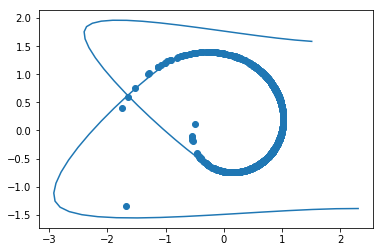

In [58]:
pl.plot(*decoder_model.predict(ttt[:, None]).T)
pl.scatter(*x_train.T)

## Model Evaluation

In [46]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

### NELBO

<IPython.core.display.Javascript object>


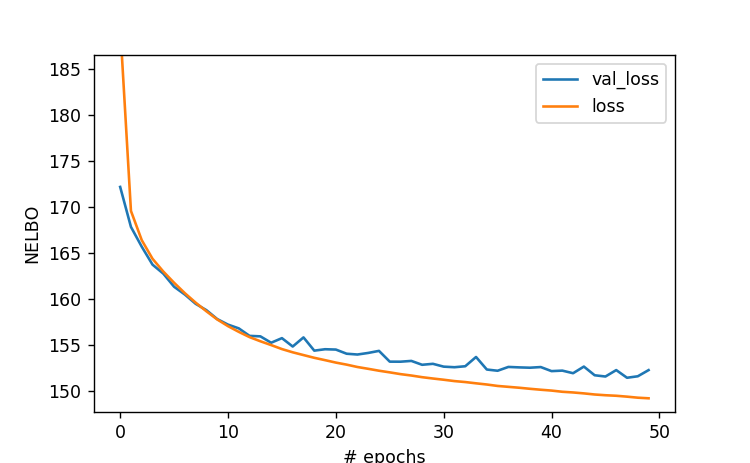

(147.70666682739258, 186.54436894226075)

In [53]:
fig, ax = pl.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())


# Bordel

In [23]:
x = Input(shape = [2], name = "x")

In [61]:
eps = Input(tensor=K.random_normal(shape = K.shape(x)))

In [62]:
y = Add()([x, eps])

In [63]:
model = Model(inputs = [x, eps], outputs = y)

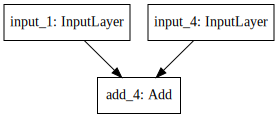

In [64]:
SVG(model_to_dot(model)
.create(prog='dot', format='svg'))

In [65]:
y.shape

TensorShape([Dimension(None), Dimension(2)])

In [66]:
x.shape

TensorShape([Dimension(None), Dimension(2)])

In [67]:
eps.shape

TensorShape([Dimension(None), Dimension(2)])

In [82]:
model.predict(x = [[[0,0], [1, 2], [1, 1]]])

array([[0.28, 0.23],
       [1.43, 1.93],
       [3.22, 1.68]], dtype=float32)